# Grading curve

This course has a curve due to [SIPA policy](https://bulletin.columbia.edu/sipa/academic-policies/grading-system-academic-progress/):

> Grades submitted for SIPA core courses must have an average GPA between 3.2 and 3.4, with the goal being 3.3. Courses with enrollments over 35 are also recommended to follow this rule.

As a compromise with Academic Affairs, the upper limit will be set to 3.8.

<!-- **This is the data/curve from Fall 2023.** It will be updated with data from this semester as we get close to the end. The grades, and thus [the resulting curve](#new-cutoffs), are expected to be similar. -->

---

## Getting your estimated course grade

1. [Open CourseWorks.](https://courseworks2.columbia.edu/courses/187089)
1. Go to `Grades`.
1. View the [current grade](https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-grades-in-a-current-course/ta-p/493).

## How course grades work

Within the `Grades` section of CourseWorks: The `Total` course grade for each student is computed as a percentage, based on the [weighted scores](https://python-public-policy.afeld.me/en/columbia/syllabus.html#assignments-and-evaluation). It also shows an estimated letter grade.

A few times during the semester:

1. The full gradebook is exported and run through this notebook.
1. The percentage required for all the letter grades is adjusted up or down as necessary to hit the target GPA range.
1. Those cutoffs are updated in CourseWorks.
1. The estimated letter grades potentially change.

The `min_score` column of the [new cutoffs](#new-cutoffs) shows the current minimum `Total` percentage required for each letter grade.

## Methodology

The rest of this notebook shows how the grade cutoffs are computed. **This methodology, the distribution of student percentages, and thus your estimated course grade are subject to change** up until final grades are submitted.

In [1]:
MIN_AVG_GPA = 3.2
MAX_AVG_GPA = 3.8

### Load current scores

The scores below are the total scores based on everything that has grades released thus far across both sections. See the timestamp in the filename below to know when it was updated. The grade data is anonymous for [privacy reasons](https://www.registrar.columbia.edu/content/privacy-rights-ferpa).

In [2]:
import pandas as pd

path = "/Users/afeld/Downloads/2024-03-20T2340_Grades-INAFU6504_ALL_2024_1_-_Python_for_Public_Policy.csv"
grades = pd.read_csv(path, skiprows=[1, 2])

# exclude the test student built into CourseWorks
grades = grades[grades["Student"] != "Student, Test"]

# obfuscate whose score is whose
grades = grades[["Current Score"]]
grades = grades.sort_values("Current Score").reset_index(drop=True)

grades

Current Score
0            0.14
1           64.91
2           77.05
3           86.21
4           86.48
..            ...
76         100.00
77         100.00
78         100.00
79         100.00
80         100.00

[81 rows x 1 columns]

#### Distribution

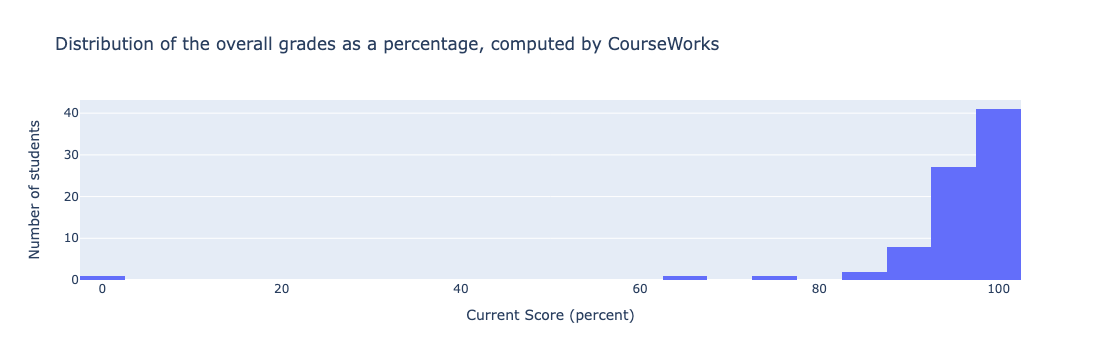

In [3]:
import plotly.express as px

fig = px.histogram(
    grades,
    x="Current Score",
    title="Distribution of the overall grades as a percentage, computed by CourseWorks",
    labels={"Current Score": "Current Score (percent)"},
)
fig.update_layout(yaxis_title_text="Number of students")
fig.show()

### Match to letter grades / GPAs

Creating the [grading notation table](https://bulletin.columbia.edu/sipa/academic-policies/grading-system-academic-progress/) in Pandas:

In [4]:
letter_grade_equivalents = pd.DataFrame(
    index=["A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D", "F"],
    data={"gpa": [4.00, 3.67, 3.33, 3.00, 2.67, 2.33, 2.00, 1.67, 1.00, 0.00]},
)

Assign starting minimum scores, roughly based on the Default Canvas Grading Scheme:

In [5]:
letter_grade_equivalents["min_score"] = [94.0, 90.0, 87.0, 84.0, 80.0, 77.0, 74.0, 70.0, 60.0, 0.0]
letter_grade_equivalents

gpa  min_score
A   4.00       94.0
A-  3.67       90.0
B+  3.33       87.0
B   3.00       84.0
B-  2.67       80.0
C+  2.33       77.0
C   2.00       74.0
C-  1.67       70.0
D   1.00       60.0
F   0.00        0.0

### Adjust cutoffs

Raise or lower the minimum scores for each grade (not including F) until the average GPA is in the acceptable range.

In [6]:
# merge_asof() needs columns sorted ascending
orig_grade_cutoffs = letter_grade_equivalents.sort_values(by="min_score")
grade_cutoffs = orig_grade_cutoffs.copy()

grades_to_adjust = grade_cutoffs.index != "F"

adjustment = 0
STEP_SIZE = 0.1

while True:
    grade_cutoffs.loc[grades_to_adjust, "min_score"] = (
        orig_grade_cutoffs[grades_to_adjust]["min_score"] + adjustment
    )

    # make the letter grades a column so they show up in the merged DataFrame
    grade_cutoffs_with_letters = grade_cutoffs.reset_index().rename(
        columns={"index": "letter_grade"}
    )

    # find the letter grade / GPA for each student
    adjusted_grades = pd.merge_asof(
        grades,
        grade_cutoffs_with_letters,
        left_on="Current Score",
        right_on="min_score",
        direction="backward",
    )

    new_mean = adjusted_grades["gpa"].mean()
    print(f"Adjustment: {adjustment:+.1f}, Average: {new_mean:.3f}")

    # check if we've hit the target range
    if MIN_AVG_GPA <= new_mean < MAX_AVG_GPA:
        # success
        break
    elif new_mean >= MAX_AVG_GPA:
        # raise
        adjustment += STEP_SIZE
    else: # new_mean < MIN_AVG_GPA:
        # lower
        adjustment -= STEP_SIZE

Adjustment: +0.0, Average: 3.811
Adjustment: +0.1, Average: 3.807
Adjustment: +0.2, Average: 3.807
Adjustment: +0.3, Average: 3.807
Adjustment: +0.4, Average: 3.803
Adjustment: +0.5, Average: 3.803
Adjustment: +0.6, Average: 3.790


Confirm the A cutoff is still achievable:

In [7]:
assert grade_cutoffs.at["A", "min_score"] <= 100

#### New cutoffs

In [8]:
grade_cutoffs.sort_values("min_score", ascending=False)

gpa  min_score
A   4.00       94.6
A-  3.67       90.6
B+  3.33       87.6
B   3.00       84.6
B-  2.67       80.6
C+  2.33       77.6
C   2.00       74.6
C-  1.67       70.6
D   1.00       60.6
F   0.00        0.0

These will be reflected in the CourseWorks [grading scheme](https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-grading-schemes/ta-p/41).

### Check results

Double-check the new average is in line with policy:

In [9]:
assert MIN_AVG_GPA <= new_mean < MAX_AVG_GPA, f"{new_mean} not in acceptable range"

new_mean

3.790246913580247

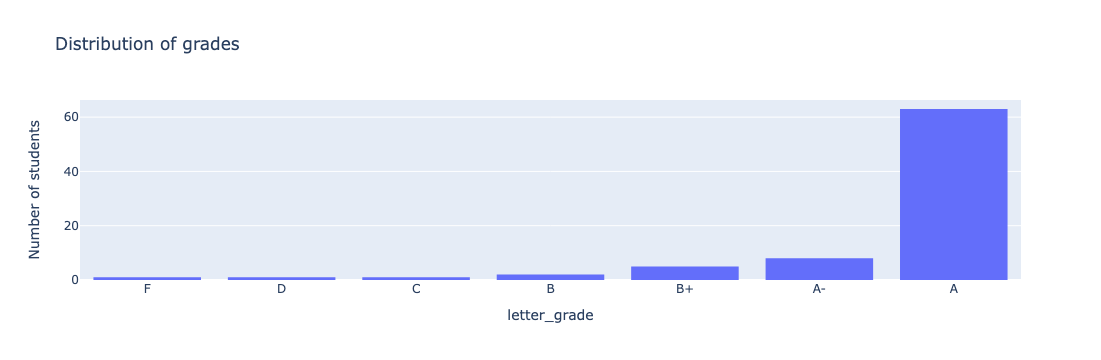

In [10]:
fig = px.histogram(adjusted_grades, x="letter_grade", title="Distribution of grades")
fig.update_layout(yaxis_title_text="Number of students")
fig.show()